In [ ]:
# ======================================================
# FeatureEngineering_simple.py
# Modular preprocessing for BETH dataset (IsolationForest friendly)
# ======================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction import FeatureHasher

# ------------------------------------------------------
# 1️⃣  单特征处理函数
# ------------------------------------------------------

def process_userId(df: pd.DataFrame) -> pd.Series:
    """userId: 二值化 + 保留外来账号强度"""
    if 'userId' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['userId']
    flag = (s >= 1000).astype(int)
    strength = np.where(s >= 1000, np.log1p(s - 999), 0)
    return pd.Series(flag, name="userId_flag"), pd.Series(strength, name="userId_log_strength")

def process_mountNamespace(df: pd.DataFrame) -> pd.Series:
    """mountNamespace: 是否等于常见值 4026531840"""
    if 'mountNamespace' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series((df['mountNamespace'] == 4026531840).astype(int), name="mountNamespace_flag")

def process_returnValue(df: pd.DataFrame) -> pd.Series:
    """returnValue: 三值化 (-1, 0, 1)"""
    if 'returnValue' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['returnValue'].fillna(0)
    mapped = s.apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
    return pd.Series(mapped, name="returnValue_mapped")

def process_argsNum(df: pd.DataFrame) -> pd.Series:
    """argsNum: 对数变换"""
    if 'argsNum' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['argsNum'].fillna(0)
    return pd.Series(np.log1p(s), name="argsNum_log")

def process_stackAddresses(df: pd.DataFrame) -> pd.Series:
    """stackAddresses: 栈深度"""
    if 'stackAddresses' not in df.columns:
        return pd.Series(0, index=df.index)
    depth = df['stackAddresses'].apply(lambda x: len(x) if isinstance(x, (list, tuple)) else 0)
    return pd.Series(np.log1p(depth), name="stack_depth_log")

def process_eventId(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """eventId: 哈希编码"""
    if 'eventId' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['eventId'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"eventId_hash_{i}" for i in range(n_features)]
    return hashed

def process_processName(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """processName: 哈希编码"""
    if 'processName' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['processName'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"processName_hash_{i}" for i in range(n_features)]
    return hashed

def process_eventName(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """eventName: 哈希编码"""
    if 'eventName' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['eventName'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"eventName_hash_{i}" for i in range(n_features)]
    return hashed

def process_parentProcessId(df: pd.DataFrame) -> pd.Series:
    """parentProcessId: 是否为系统级(0,1,2)"""
    if 'parentProcessId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['parentProcessId'].isin([0,1,2]).astype(int), name="parentPID_sys_flag")

def process_processId(df: pd.DataFrame) -> pd.Series:
    """processId: 是否为系统级(0,1,2)"""
    if 'processId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['processId'].isin([0,1,2]).astype(int), name="process_sys_flag")

def Wangprocess_someFeature(df: pd.DataFrame) -> pd.Series:
    """示例自定义特征处理函数"""
    # 用户可根据需要添加更多特征处理函数
    # 2. 根据论文建议进行特征转换和选择
    # 保留 'eventId' 和 'argsNum'
    processed_df = pd.Series(index=df.index)
    processed_df['eventId'] = df['eventId']
    processed_df['argsNum'] = df['argsNum']

    # processId: 如果ID是0, 1, or 2，则为1，否则为0
    processed_df['processId_is_os'] = df['processId'].isin([0, 1, 2]).astype(int)

    # parentProcessId: 规则同processId
    processed_df['parentProcessId_is_os'] = df['parentProcessId'].isin([0, 1, 2]).astype(int)

    # userId: 如果ID < 1000，则为1 (系统活动)，否则为0 (用户活动)
    processed_df['userId_is_os'] = (df['userId'] < 1000).astype(int)

    # mountNamespace: 如果值为 4026531840，则为1，否则为0
    processed_df['mountNamespace_is_default'] = (df['mountNamespace'] == 4026531840).astype(int)

    # returnValue: 映射为-1, 0, 1三种状态
    # <0 映射为 -1 (error)
    # =0 映射为 0 (success)
    # >0 映射为 1 (success with signal)
    processed_df['returnValue_mapped'] = df['returnValue'].apply(lambda x: -1 if x < 0 else (0 if x == 0 else 1))
    return processed_df

# ------------------------------------------------------
# 2️⃣  主控制函数
# ------------------------------------------------------

def preprocess(df: pd.DataFrame, n_hash_features: int = 32) -> pd.DataFrame:
    """
    主预处理函数：调用各单独特征函数，并拼接为模型可用 DataFrame。
    """

    feats = []

    # === 数值 / 二值类 ===
    uflag, ulog = process_userId(df)
    feats += [uflag, ulog,
              process_mountNamespace(df),
              process_returnValue(df),
              process_argsNum(df),
              process_stackAddresses(df),
              process_parentProcessId(df),
              process_processId(df)]

    # === 类别哈希类 ===
    feats.append(process_eventId(df, n_features=n_hash_features))
    feats.append(process_processName(df, n_features=n_hash_features))
    feats.append(process_eventName(df, n_features=n_hash_features))

    # === 自定义特征类 ===
    feats.append(Wangprocess_someFeature(df))

    # 拼接所有结果
    df_out = pd.concat(feats, axis=1)

    # 缺失值统一填 0
    df_out = df_out.fillna(0)

    # 只保留数值
    df_out = df_out.select_dtypes(include=[np.number])

    return df_out

# ------------------------------------------------------
# 3️⃣  示例
# ------------------------------------------------------
# if __name__ == "__main__":
#     df = pd.read_csv("BETH_subset.csv")  # 示例输入
#     df_feat = preprocess(df, n_hash_features=32)
#     print("✅ Preprocessed shape:", df_feat.shape)
#     print("✅ Columns sample:", df_feat.columns[:10].tolist())
#     df_feat.to_csv("BETH_features_ready.csv", index=False)


In [21]:
df_train = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_train.csv")  
df_test = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_test.csv")  
df_valid = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_valid.csv")

In [22]:
df_train_feat = preprocess(df_train, n_hash_features=32)
df_test_feat = preprocess(df_test, n_hash_features=32)
df_valid_feat = preprocess(df_valid, n_hash_features=32)

c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df_train_feat.shape
df_train_feat.head()

df_train_feat.head().to_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\df_train_feat_sample.csv", index=False)

In [23]:
df_valid_feat.shape
df_valid_feat.head()

,userId_flag,userId_log_strength,mountNamespace_flag,returnValue_mapped,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,eventId_hash_0,eventId_hash_1,...,eventName_hash_22,eventName_hash_23,eventName_hash_24,eventName_hash_25,eventName_hash_26,eventName_hash_27,eventName_hash_28,eventName_hash_29,eventName_hash_30,eventName_hash_31
0,0.0,0.0,0.0,1.0,1.386294,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.693147,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.098612,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.693147,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.609438,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_test_feat.shape
df_test_feat.head()

,userId_flag,userId_log_strength,mountNamespace_flag,returnValue_mapped,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,eventId_hash_0,eventId_hash_1,...,eventName_hash_22,eventName_hash_23,eventName_hash_24,eventName_hash_25,eventName_hash_26,eventName_hash_27,eventName_hash_28,eventName_hash_29,eventName_hash_30,eventName_hash_31
0,0,0.0,1,0,1.098612,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,1,0,0.693147,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,1,0,0.693147,0.0,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,1,0,0.693147,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,1,1,1.609438,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# 保存 Id 列
test_ids = df_test["Id"].copy()  
test_ids.head()

0    0
1    1
2    2
3    3
4    4
Name: Id, dtype: int64

In [12]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(
    n_estimators=100,
    contamination=0.005,
    max_features=0.6,
    max_samples=0.6,
    random_state=42,
    n_jobs=-1
)
# model = IsolationForest(
#     n_estimators=150,
#     contamination=0.04,
#     max_features=1.0,
#     max_samples=20000,
#     random_state=42,
#     n_jobs=-1
# )
model.fit(df_train_feat)

,n_estimators,100
,max_samples,0.6
,contamination,0.005
,max_features,0.6
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score, precision_recall_fscore_support
# ========== 5. 模型评估 ==========
print("\nMaking predictions on validation data...")
y_valid_target = df_valid['target']

# 异常分数（越大越异常）
scores = -model.decision_function(df_valid_feat)
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
# Average Precision
ap = average_precision_score(y_valid_target, scores_norm)
# 固定 percentile=97 计算 F1、P、R
thr = np.percentile(scores_norm, 97)
y_pred = (scores_norm >= thr).astype(int)
p, r, f1, _ = precision_recall_fscore_support(y_valid_target, y_pred, average="binary")

print("\nModel Evaluation:" + "precision: {:.4f}, recall: {:.4f}, F1-score: {:.4f}, AP: {:.4f}".format(p, r, f1, ap))
#print("Accuracy:", accuracy_score(y_valid_target, y_pred))
#print("\nConfusion Matrix:")
#print(confusion_matrix(y_valid_target, y_pred))
#print("\nClassification Report:")
#print(classification_report(y_valid_target, y_pred, zero_division=0))


Making predictions on validation data...

Model Evaluation:precision: 0.7110, recall: 0.5597, F1-score: 0.6263, AP: 0.7165


# test

In [32]:
# Evaluating combination 1/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.005, 'random_state': 42}
# ========== 5. 模型测试 》》》 输出csv文件，提交kaggle ==========
print("\nMaking predictions on test data...")
# 手动设置阈值 percentile = 0.97
# === 3️⃣ 手动设置阈值 percentile = 97 ===
# === 2️⃣ 计算测试集异常分数 ===
score_test = -model.decision_function(df_test_feat)
# === 2️⃣ 将异常分数归一化到 [0, 1] ===
score_norm = (score_test - score_test.min()) / (score_test.max() - score_test.min())
# === 3️⃣ 构建提交 DataFrame ===
submission = pd.DataFrame({
    "Id": df_test["Id"],   # ⚠️ 必须与你的 processes_test.csv 中的 Id 对应
    "target": score_norm               # Kaggle 要求列名为 target
})

# === 4️⃣ 保存为 CSV 文件（无 index） ===
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv 已生成，可直接上传至 Kaggle！")


Making predictions on test data...
✅ submission.csv 已生成，可直接上传至 Kaggle！


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import (
#     average_precision_score, 
#     precision_recall_fscore_support
# )
# from itertools import product

# # =============================
# # 参数网格定义
# # =============================
# param_grid = {
#     "n_estimators": [100, 200],
#     "max_samples": [0.6, 0.8, 1.0],
#     "max_features": [0.6, 0.8, 1.0],
#     "contamination": [0.005, 0.008, 0.015],
#     "random_state": [42]
# }

# # 展开网格为组合列表
# keys, values = zip(*param_grid.items())
# param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# # =============================
# # 定义评估函数
# # =============================
# def evaluate_isoforest(params, X_train, X_valid, y_valid, percentile=97):
#     """训练 IsolationForest 并返回验证集指标"""
#     model = IsolationForest(**params, n_jobs=-1)
#     model.fit(X_train)
    
#     # 异常分数（越大越异常）
#     scores = -model.decision_function(X_valid)
#     scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
    
#     # 平均精度 AP
#     ap = average_precision_score(y_valid, scores_norm)
    
#     # 固定分位数阈值，计算 Precision/Recall/F1
#     thr = np.percentile(scores_norm, percentile)
#     y_pred = (scores_norm >= thr).astype(int)
#     p, r, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average="binary")
    
#     return {
#         "params": params,
#         "precision": p,
#         "recall": r,
#         "f1": f1,
#         "ap": ap
#     }

# # =============================
# # 主循环：网格搜索
# # =============================
# results = []

# for i, params in enumerate(param_combinations, 1):
#     print(f"▶ Evaluating combination {i}/{len(param_combinations)}: {params}")
#     metrics = evaluate_isoforest(params, df_train_feat, df_valid_feat, df_valid["target"])
#     results.append(metrics)
#     # ✅ 实时打印当前性能
#     print(f"[{i:02d}/{len(param_combinations)}] "
#           f"n_est={params['n_estimators']}, samp={params['max_samples']}, feat={params['max_features']}, cont={params['contamination']} "
#           f"→ P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f}, AP={metrics['ap']:.4f}")

# # 转为 DataFrame
# results_df = pd.DataFrame(results)

# # =============================
# # 输出结果
# # =============================
# results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)

# print("\n===== Grid Search Summary =====")
# print(results_df[["params", "precision", "recall", "f1", "ap"]])

# best_params = results_df.loc[0, "params"]
# print("\n✅ Best parameter combination:")
# for k, v in best_params.items():
#     print(f"  {k}: {v}")

# # =============================
# # 可视化 F1 对比（可选）
# # =============================
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 4))
# plt.plot(results_df["f1"].values, marker="o")
# plt.xlabel("Parameter combination index")
# plt.ylabel("F1 score")
# plt.title("IsolationForest Parameter Grid Search")
# plt.grid(True)
# plt.show()


▶ Evaluating combination 1/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.005, 'random_state': 42}
[01/54] n_est=100, samp=0.6, feat=0.6, cont=0.005 → P=0.9193, R=0.7484, F1=0.8251, AP=0.8887
▶ Evaluating combination 2/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.008, 'random_state': 42}
[02/54] n_est=100, samp=0.6, feat=0.6, cont=0.008 → P=0.9193, R=0.7484, F1=0.8251, AP=0.8887
▶ Evaluating combination 3/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.015, 'random_state': 42}
[03/54] n_est=100, samp=0.6, feat=0.6, cont=0.015 → P=0.9193, R=0.7484, F1=0.8251, AP=0.8887
▶ Evaluating combination 4/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.8, 'contamination': 0.005, 'random_state': 42}
[04/54] n_est=100, samp=0.6, feat=0.8, cont=0.005 → P=0.8347, R=0.6614, F1=0.7380, AP=0.8281
▶ Evaluating combination 5/54: {'n_estimators': 100, 'max_samples': 0.6, 'ma

KeyboardInterrupt: 

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# 统一分数定义：越大越异常
scores = -model.decision_function(df_valid_feat)
y_valid_target = df_valid['target']
ap = average_precision_score(y_valid_target, scores)

prec, rec, thr = precision_recall_curve(y_valid_target, scores)

print(f"AP={ap:.4f},  MaxPrecision@AnyRecall={prec.max():.4f}")

# 看你固定97分位在曲线上的位置
p97 = np.percentile(scores, 97)
yp97 = (scores >= p97).astype(int)
from sklearn.metrics import precision_recall_fscore_support
P,R,F1,_ = precision_recall_fscore_support(y_valid_target, yp97, average="binary")
print(f"@97th → P={P:.4f}, R={R:.4f}, F1={F1:.4f}")


AP=0.8887,  MaxPrecision@AnyRecall=1.0000
@97th → P=0.9193, R=0.7484, F1=0.8251


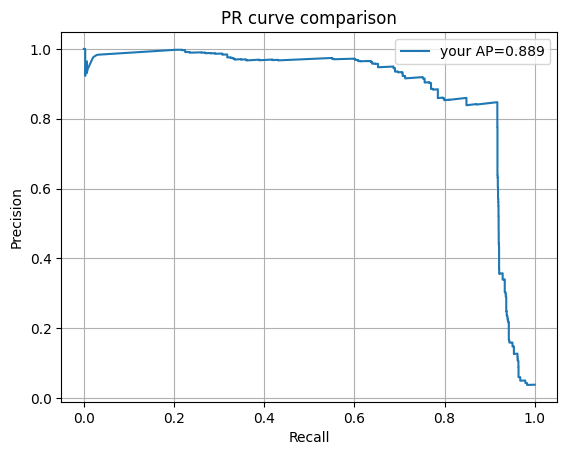

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# scores1 = -isoModel.decision_function(x_valid)     # 左模型
scores2 = -model.decision_function(df_valid_feat)  # 右模型
y = y_valid_target

# ap1 = average_precision_score(y, scores1)
ap2 = average_precision_score(y, scores2)

# print(f"AP1={ap1:.4f}, AP2={ap2:.4f}")

import matplotlib.pyplot as plt
# prec1, rec1, _ = precision_recall_curve(y, scores1)
prec2, rec2, _ = precision_recall_curve(y, scores2)
# plt.plot(rec1, prec1, label=f'ipynb AP={ap1:.3f}')
plt.plot(rec2, prec2, label=f'your AP={ap2:.3f}')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True)
plt.title("PR curve comparison")
plt.show()